# Setup

In [1]:
# Uncomment and run them to download ckpts, configs and datasets.

# !mkdir -p logs/2020-11-09T13-31-51_sflckr/checkpoints
# !wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt'
# !mkdir logs/2020-11-09T13-31-51_sflckr/configs
# !wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml'

In [2]:
from omegaconf import OmegaConf
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import sys
sys.path.append(".")
project_path = "/home/lyk/Projects/taming-transformers" # Change this!!!
config_path = "logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml"
ckpt_path = "logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt"

# image_directory_path = f"{project_path}/data/coco_images"
image_directory_path = f"{project_path}/my_data/flickr30k_images"
# image_directory_path = f"{project_path}/my_data/test_images"


file_path_to_save = f"{project_path}/outputs/result.pth"
# Check if CUDA is available

torch.set_grad_enabled(False)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

target_image_size = 256  # Optional: Resize all images to (H, W) while H=W
batch_size=32


# Loading the model

In [4]:

config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

data:
  params:
    batch_size: 1
    validation:
      target: taming.data.sflckr.Examples
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 182
          num_res_blocks: 2
          out_ch: 182
          resolution: 256
          z_channels: 256
        embed_dim: 256
        image_key: segmentation
        lossconfig:
          target: taming.modules.losses.DummyLoss
        n_embed: 1024
      target: taming.models.vqgan.VQModel
    cond_stage_key: segmentation
    first_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          doub

Instantiate the mdoel

In [5]:
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/lyk/miniconda3/envs/taming/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the checkpoint

In [6]:
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
model.to(DEVICE)

Net2NetTransformer(
  (first_stage_model): VQModel(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down): ModuleList(
        (0-1): 2 x Module(
          (block): ModuleList(
            (0-1): 2 x ResnetBlock(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
          (attn): ModuleList()
          (downsample): Downsample(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
        (2): Module(
          (block): ModuleList(
            (0): ResnetBlock(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (co

In [7]:
model.eval()

torch.set_grad_enabled(False)

# Load dataset

In [8]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

class ImageDataset(Dataset):
    def __init__(self, directory, target_image_size=128):
        self.directory = directory
        self.filenames = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.jpg', '.png'))]
        self.target_image_size = target_image_size
        self.size_filter_stats = {'valid': 0, 'invalid': 0}  # Initialize statistics

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        while True:
            img_path = self.filenames[idx]
            img = Image.open(img_path).convert('RGB')
            try:
                img = preprocess(img, target_image_size=self.target_image_size)
                img = preprocess_vqgan(img)
                self.size_filter_stats['valid'] += 1  # Increment valid count
                return img
            except ValueError:
                self.size_filter_stats['invalid'] += 1  # Increment invalid count
                idx = (idx + 1) % len(self.filenames)

    def get_size_filter_stats(self):
        return self.size_filter_stats

def preprocess(img, target_image_size=128):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = T.ToTensor()(img)  # Remove torch.unsqueeze
    return img



def preprocess_vqgan(x):
    '''
    Why?
    '''
    x = 2. * x - 1.
    return x
def delete_small_images(directory, target_image_size):
    """
    Delete images in the specified directory whose height or width is less than the target image size.

    Args:
        directory (str): Path to the directory containing the images.
        target_image_size (int): The minimum size for both height and width of the images.
    """
    deleted_count = 0

    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):  # Add other extensions as needed
            image_path = os.path.join(directory, filename)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    if width < target_image_size or height < target_image_size:
                        os.remove(image_path)
                        deleted_count += 1
                        print(f"Deleted {filename} (size: {width}x{height})")
            except Exception as e:
                print(f"Error processing {filename}: {e}")
delete_small_images(image_directory_path, target_image_size=target_image_size)
dataset = ImageDataset(image_directory_path, target_image_size=target_image_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)



Deleted 3587077732.jpg (size: 214x500)
Deleted 3179833180.jpg (size: 500x246)
Deleted 2574824768.jpg (size: 500x189)
Deleted 4612587813.jpg (size: 500x249)
Deleted 247874544.jpg (size: 254x500)
Deleted 3381747300.jpg (size: 216x500)
Deleted 4752463128.jpg (size: 500x191)
Deleted 4614283206.jpg (size: 500x238)
Deleted 473113241.jpg (size: 244x500)
Deleted 4903277818.jpg (size: 500x240)
Deleted 437917001.jpg (size: 500x252)
Deleted 3683644335.jpg (size: 500x192)
Deleted 23015660.jpg (size: 253x500)
Deleted 3380643902.jpg (size: 500x239)
Deleted 4922641559.jpg (size: 207x500)
Deleted 7992914279.jpg (size: 500x233)
Deleted 3331797838.jpg (size: 500x219)
Deleted 7764955218.jpg (size: 500x246)
Deleted 3143032614.jpg (size: 500x197)
Deleted 422763475.jpg (size: 244x500)
Deleted 316577571.jpg (size: 500x253)
Deleted 4729067306.jpg (size: 500x254)
Deleted 6854823446.jpg (size: 500x225)
Deleted 5989324335.jpg (size: 500x231)
Deleted 1295671216.jpg (size: 200x500)
Deleted 3091921457.jpg (size: 40

# Do the forward pass of VQ-GAN

In [9]:
all_z_q = []
all_indices_unflattened = []
all_images = []

for img_batch in dataloader:
    img_batch = img_batch.to(DEVICE) 
    # img --> z_q: (B, C, H, W) --> (B, D, h, w)
    z_q, indices = model.encode_to_z(img_batch) 
    B, D, h, w = z_q.shape
    assert h * w == indices.shape[1]  # Assert that len(indices)==h*w
    
    indices_unflattened = indices.reshape(B, h, w)  # (B, h, w)

    all_z_q.append(z_q)
    all_indices_unflattened.append(indices_unflattened)
    # all_images.append(img_batch)
    # print(z_q.shape)
    
    
# Concatenate all collected z_q and indices_unflattened tensors
all_z_q = torch.cat(all_z_q, dim=0)
all_indices_unflattened = torch.cat(all_indices_unflattened, dim=0)
# all_images = torch.cat(all_images, dim=0)
# Print the statistics
stats = dataset.get_size_filter_stats()
print(f"Number of valid images: {stats['valid']}")
print(f"Number of invalid images (too small): {stats['invalid']}")


# The rest of your code to process the concatenated tensors
B, D, h, w = all_z_q.shape
print(f'''
          Batch size = {B},
          Code dimension = {D},
          Embedding height = {h},
          Embedding width = {w} 
          ''')

/home/lyk/miniconda3/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


Number of valid images: 31461
Number of invalid images (too small): 0

          Batch size = 31461,
          Code dimension = 256,
          Embedding height = 16,
          Embedding width = 16 
          


In [10]:
D = config.model.params.first_stage_config.params.embed_dim # D := the dimension number of each code e_k in the codebook.
K = config.model.params.first_stage_config.params.n_embed # codebook size

indices_flattened = all_indices_unflattened.view(-1)  # Shape: (B*h*w,)
unique_indices = indices_flattened.unique()
    
z_q_flattened = all_z_q.permute(0, 2, 3, 1).reshape(-1, D)  # Shape: (B*h*w, D)
    
# Initialize the codebook (K, D)
codebook = torch.zeros((K, D), device=all_z_q.device, dtype=all_z_q.dtype)
    
# Populate the codebook
for idx in unique_indices:
    codebook[idx] = z_q_flattened[indices_flattened == idx].mean(dim=0)

print("Codebook shape:", codebook.shape)
print("Codebook:", codebook)

Codebook shape: torch.Size([1024, 256])
Codebook: tensor([[ 0.2046, -0.8589, -0.1892,  ..., -0.1544,  0.8922,  0.2580],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8011, -1.9389, -0.9249,  ..., -0.7664,  0.5944,  0.6733],
        [-0.9394, -0.4141, -1.2881,  ...,  0.3234, -0.6580, -1.4466],
        [ 0.0707, -1.0961, -1.6857,  ...,  1.1182,  1.0006, -1.1370]],
       device='cuda:0')


In [11]:
# Assuming you have the following variables already defined:
# z_q: The encoded tensor of shape (B, D, h, w)
# indices_unflattened: The indices tensor of shape (B, h, w)
# D: The dimension of each code
# K: The number of unique codes in the codebook

# Step 1: Flatten indices_unflattened to get a 1D array of indices
indices_flattened = indices_unflattened.view(-1)  # Shape: (B*h*w,)

# Step 2: Get unique indices
unique_indices = indices_flattened.unique()

# Step 3: Gather the codes from z_q based on unique indices
# We need to reshape z_q to (B*h*w, D) to easily gather the codes
z_q_flattened = z_q.permute(0, 2, 3, 1).reshape(-1, D)  # Shape: (B*h*w, D)

# Initialize the codebook (K, D)
codebook = torch.zeros((K, D), device=z_q.device, dtype=z_q.dtype)

# Populate the codebook

# Fill the codebook with the mean of the vectors corresponding to each unique index.
# Creates a boolean mask where elements are True if they match the current idx and False otherwise.
# Uses this boolean mask to select all vectors in z_q_flattened that correspond to the current idx.
# Computes the mean of the selected vectors along the 0th dimension (which is the batch dimension). This results in a single vector of shape (D,) which represents the average vector for the current idx.
for idx in unique_indices:
    codebook[idx] = z_q_flattened[indices_flattened == idx].mean(dim=0)

print("Codebook shape:", codebook.shape)
print("Codebook:", codebook)

Codebook shape: torch.Size([1024, 256])
Codebook: tensor([[ 0.2046, -0.8589, -0.1892,  ..., -0.1544,  0.8922,  0.2580],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8011, -1.9389, -0.9249,  ..., -0.7664,  0.5944,  0.6733],
        [-0.9394, -0.4141, -1.2881,  ...,  0.3234, -0.6580, -1.4466],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')


# Save the results
Save the feature map (`z_q`), indices, codebook and original image.

In [12]:
res = {
  "z_q": all_z_q, # (B, D, h, w)
  "indices": all_indices_unflattened, # (B, h, w)
  "codebook": codebook, # (K, D)
  # "image": img_batch, # float, tensor
}
# Here `B` is the total dataset size.



# Save the dictionary to the specified file path
torch.save(res, file_path_to_save)

print(f"Dictionary saved to {file_path_to_save}")

Dictionary saved to /home/lyk/Projects/taming-transformers/outputs/result.pth


# Load the results and visualize them

In [14]:
import matplotlib.pyplot as plt

# Load the dictionary from the file
loaded_res = torch.load(file_path_to_save)

# Access the images and indices from the loaded dictionary
# img_batch = loaded_res["image"]
indices = loaded_res["indices"]
codebook = loaded_res["codebook"]






In [ ]:
# # Function to visualize the images
# def visualize_images(img_batch):
#     """
#     Visualize all images in the batch.

#     Args:
#         img_batch (torch.Tensor): Batch tensor of shape (B, C, H, W).
#     """
#     B, C, H, W = img_batch.shape
#     img_batch = img_batch.cpu().numpy()  # Move to CPU and convert to numpy

#     # If the images are in the format (B, C, H, W), we need to transpose them to (B, H, W, C)
#     img_batch = img_batch.transpose(0, 2, 3, 1)

#     for i in range(B):
#         img = img_batch[i]
#         img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
#         plt.figure(figsize=(6, 6))
#         plt.imshow(img)
#         plt.title(f'Image {i+1}')
#         plt.axis('off')
#         plt.show()

# # Visualize the first 8 images
# visualize_images(img_batch[:8])

visualize the histogram of indices

Unused indices (total 574): [   1    2    3    5    8    9   10   11   14   15   16   17   18   21
   22   23   24   25   26   30   33   34   38   41   42   43   45   46
   50   51   52   53   59   60   62   64   65   67   68   69   70   71
   73   74   75   76   77   78   79   81   85   86   87   88   89   90
   91   93   95   97   98   99  100  101  103  104  105  106  108  109
  111  113  114  115  116  118  121  123  124  127  130  131  133  135
  137  138  139  141  142  145  146  149  151  152  153  155  157  158
  159  160  161  162  165  167  169  170  174  177  178  179  180  181
  182  183  190  191  194  195  196  197  198  199  201  203  204  205
  207  209  211  212  213  214  216  221  223  224  227  228  229  231
  232  233  234  235  236  238  239  240  241  242  246  249  251  252
  259  262  264  265  266  267  268  269  270  271  272  273  274  275
  277  278  279  280  281  282  284  285  286  288  289  290  291  292
  293  296  298  300  302  303  305  307  309  31

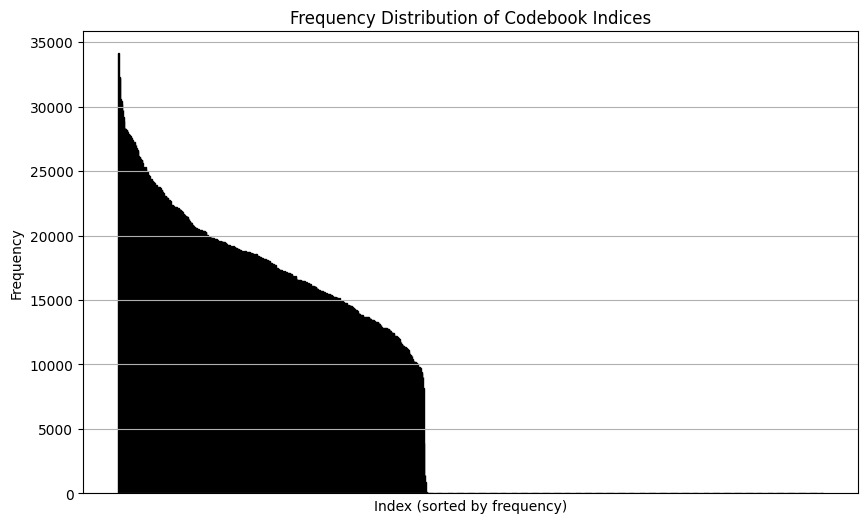

In [21]:

import matplotlib.pyplot as plt
import numpy as np

def calculate_shannon_entropy(probabilities):
    """
    Calculate the Shannon entropy of a probability distribution.
    
    Args:
        probabilities (np.ndarray): Array of probabilities.
    
    Returns:
        float: The Shannon entropy.
    """
    # Filter out zero probabilities to avoid log(0)
    probabilities = probabilities[probabilities > 0]
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def visualize_indices_frequency_distribution(indices, codebook_size):
    """
    Visualize the distribution of indices as frequencies using a bar plot, sorted by frequency in descending order.

    Args:
        indices (torch.Tensor): Tensor of shape (B, h, w) containing the indices.
        codebook_size (int): The number of codes in the codebook.
    """
    indices_flattened = indices.view(-1).cpu().numpy()
    
    # Count the occurrences of each index
    index_counts = np.bincount(indices_flattened, minlength=codebook_size)
    
    # Find unused indices
    unused_indices = np.where(index_counts == 0)[0]
    
    if len(unused_indices) > 0:
        print(f"Unused indices (total {len(unused_indices)}): {unused_indices}")
    else:
        print("All indices are used at least once.")
    
    # Calculate probabilities
    total_count = np.sum(index_counts)
    probabilities = index_counts / total_count
    
    # Calculate Shannon entropy
    entropy = calculate_shannon_entropy(probabilities)
    print(f"Shannon entropy: {entropy}")
    
    # Sort indices by frequency in descending order
    sorted_indices = np.argsort(index_counts)[::-1]
    sorted_counts = index_counts[sorted_indices]
    # print(sorted_indices[-1], sorted_counts[-1])
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(codebook_size), sorted_counts, color='skyblue', edgecolor='black')
    plt.title('Frequency Distribution of Codebook Indices')
    plt.xlabel('Index (sorted by frequency)')
    plt.ylabel('Frequency')
    
    # Optionally, hide x-axis labels if there are too many indices
    if codebook_size > 50:  # Adjust the threshold as needed
        plt.xticks([])
    
    plt.grid(True)
    plt.show()

# Visualize the probability distribution of indices
codebook_size = codebook.shape[0]
visualize_indices_frequency_distribution(indices, codebook_size)


In [22]:
2**8.74924007607881

430.31224261000375

 visualize the codebook

In [ ]:
# Function to visualize the codebook
def visualize_codebook(codebook):
    """
    Visualize the codebook as an image grid.

    Args:
        codebook (torch.Tensor): Tensor of shape (K, D) where K is the number of codes and D is the dimension.
    """
    K, D = codebook.shape
    codebook = codebook.cpu().numpy()  # Move to CPU and convert to numpy

    # Reshape the codebook to visualize it
    codebook_image = codebook.reshape((int(np.sqrt(K)), int(np.sqrt(K)), int(np.sqrt(D)), int(np.sqrt(D))))
    codebook_image = codebook_image.transpose(0, 2, 1, 3).reshape(int(np.sqrt(K)) * int(np.sqrt(D)), int(np.sqrt(K)) * int(np.sqrt(D)))

    plt.figure(figsize=(10, 10))
    plt.imshow(codebook_image, cmap='viridis')
    plt.title('Codebook Visualization')
    plt.axis('off')
    plt.show()

# Visualize the codebook
visualize_codebook(codebook)